In [1]:
import sys
import time

import matplotlib.pyplot as plt
import numpy
import numpy as np
import scipy.stats
from sklearn.decomposition import FastICA
from tvb.basic.logger.builder import get_logger
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator import coupling, integrators, models, monitors, noise
from tvb.simulator.simulator import Simulator

import utils

LOG = get_logger("demo")

# Introduction

Fluctuations in brain activity in non-task conditions are now a well-established phenomena in the literature. These fluctuations are not random but shown to exhibit spatial patterns, referred to as resting state networks. Despite being readily identifiable during rest, these networks are related to specific functions and on the other hand abnormalities in such RSNs have been associated with pathology.

In the following, we will demonstrate some starting points for modeling resting state networks in TVB, using the default data set.

# Setting up the simulation

In the following, we'll use a basic region level simulation, with the generic oscillator set in an excitable regime, linear coupling with low strength, a stochastic integrator with low noise and a temporal average monitor at 200 Hz.

These settings are a good starting point for modeling resting state patterns because no particular factor dominates the dynamics and a balance between the structural connectivity, moderate intrinsic excitability and noise comes into play.

In [2]:
import utils

In [3]:
def run_sim(conn, cs, D, cv=3.0, dt=0.5, simlen=1e3):
    sim = Simulator(
        model=models.Generic2dOscillator(a=numpy.array([0.0])),
        connectivity=conn,
        coupling=coupling.Linear(a=numpy.array([cs])),
        integrator=integrators.HeunStochastic(
            dt=dt, noise=noise.Additive(nsig=np.array([D]))
        ),
        monitors=(monitors.TemporalAverage(period=5.0),),  # 200 Hz
    )
    sim.configure()
    ((t, y),) = sim.run(simulation_length=simlen)
    return t, y[:, 0, :, 0]


conn = Connectivity(
    tract_lengths=utils.lengths,
    weights=utils.weights,
    centres=np.array([0.0] * utils.weights.shape[0]),
    orientations=np.array([0.0] * utils.weights.shape[0]),
    region_labels=np.array(utils.region_labels, dtype=str),
)
conn.configure()
conn.weights = 0.5 * conn.scaled_weights(mode="tract")

# conn = Connectivity.from_file()

One of the common features of simulations is an initial transient, so we'll perform a one minute simulation, and as soon as the time series have been generated, we check that the transient has decayed:

In [4]:
tic = time.time()
t, y = run_sim(conn, cs=6e-2, D=5e-4, simlen=1 * 60e3)
"simulation required %0.3f seconds." % (time.time() - tic,)

2024-05-15 22:14:30,890 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB
2024-05-15 22:14:30,891 - INFO - tvb.simulator.history - sparse history has n_nnzw=6972, i.e. 98.81 % sparse


# Functional Connectivity

Next, to quickly assess the presence of a network structure in the time series, we window the time series into 1 second non overlapping windows, obtain per-window correlation matrices

In [ ]:
def calculate_fc(t, y):
    cs = []
    for i in range(int(t[-1] / 1e3)):
        cs.append(np.corrcoef(y[(t > (i * 1e3)) * (t < (1e3 * (i + 1)))].T))
    cs = np.array(cs)
    return cs


def ttest(cs):
    cs_z = np.arctanh(cs)
    for i in range(cs.shape[1]):
        cs_z[:, i, i] = 0.0
    _, p = scipy.stats.ttest_1samp(cs, 0.0)
    return p

The strength of correlation can be assessed statistically by Fisher Z transforming the coefficients and applying a t-test,

In [ ]:
cs = calculate_fc(t, y)
p = ttest(cs)

/var/folders/ym/9kw1g21j1nd7kwfn8c0z3st40000gn/T/ipykernel_53376/583554036.py:10: RuntimeWarning: divide by zero encountered in arctanh
  cs_z = np.arctanh(cs)
/Users/leonmartin_bih/projects/PresentationsAndWorkshops/ILAE2024/TVB-Processing/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


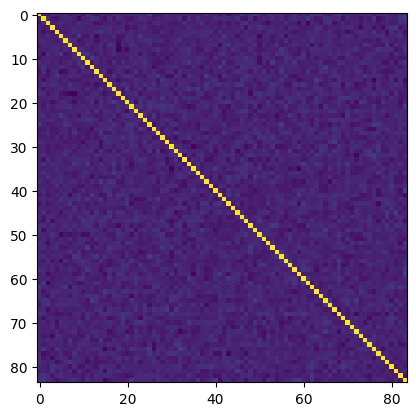

In [ ]:
plt.imshow(np.corrcoef(y[1000:], rowvar=False))

Which we then visualize the structural connectivity (left) and functional connectivity (right) as an adjacency matrices applying a threshold on significance:

/var/folders/ym/9kw1g21j1nd7kwfn8c0z3st40000gn/T/ipykernel_53376/3466955961.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(p) * (p < 0.05), cmap="viridis", interpolation="none"


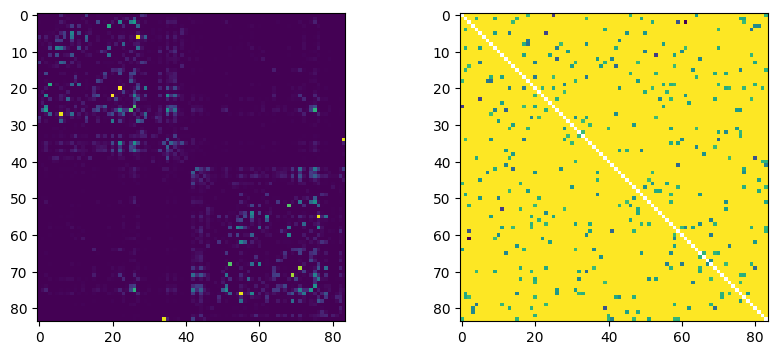

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121), plt.imshow(conn.weights, cmap="viridis", interpolation="none")
plt.subplot(122), plt.imshow(
    np.log10(p) * (p < 0.05), cmap="viridis", interpolation="none"
)
plt.show()

We can see there are significant deviations in the FC from the SC which are especially prominent in the interhemispheric FC, where interactions are found despite limited interhemispheric SC.

We can then ask what degree of similarity there is between the average functional connectivity and the structural connectivity, and how it varies over time:

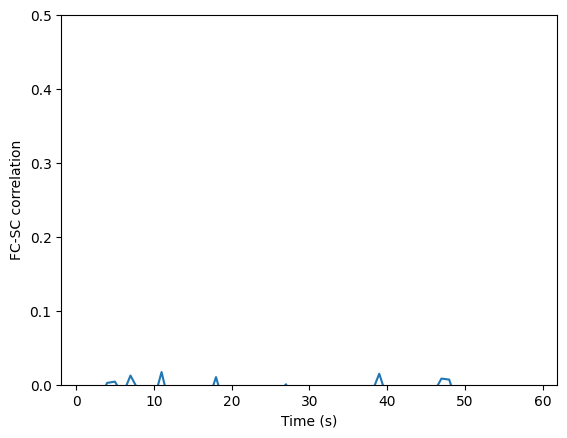

In [ ]:
plt.figure()
plt.plot(
    np.r_[1 : len(cs) + 1],
    [np.corrcoef(cs_i.ravel(), conn.weights.ravel())[0, 1] for cs_i in cs],
)
plt.ylim([0, 0.5])
plt.ylabel("FC-SC correlation")
plt.xlabel("Time (s)")
plt.show()

In [ ]:
import concurrent.futures


def fc_corr(fc1, fc2):
    return np.corrcoef(fc1.flatten(), fc2.flatten())[0, 1]


G_range = np.linspace(0, 1, 10)


def process_G(G, run_sim, fc_emp):
    t, y = run_sim(conn, cs=G, D=5e-4, simlen=10 * 60e3)
    fc = calculate_fc(t[1000:], y[1000:])
    p = ttest(fc)
    corr = fc_corr(p, fc_emp)
    print(G, corr)
    return corr, p


def explore_G_multithreaded(G_range, gm, fc):
    fc_rs = []
    fcs = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Use map to execute the function over the array of G values
        results = executor.map(
            process_G,
            G_range,
            [gm] * len(G_range),
            [fc] * len(G_range),
        )
        for result in results:
            fc_r, fc_G = result
            fc_rs.append(fc_r)
            fcs.append(fc_G)
    return fc_rs, fcs


# Call the multithreaded function
fc_corr_mfm, fcs_mfm = explore_G_multithreaded(G_range, run_sim, utils.fc.values)

2024-05-15 21:19:20,122 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB


2024-05-15 21:19:20,123 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB
2024-05-15 21:19:20,124 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB
2024-05-15 21:19:20,125 - INFO - tvb.simulator.history - sparse history has n_nnzw=6972, i.e. 98.81 % sparse
2024-05-15 21:19:20,125 - INFO - tvb.simulator.history - sparse history has n_nnzw=6972, i.e. 98.81 % sparse
2024-05-15 21:19:20,125 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB
2024-05-15 21:19:20,126 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB
2024-05-15 21:19:20,126 - INFO - tvb.simulator.history - history has n_time=150 n_cvar=1 n_node=84 n_nmode=1, requires 0.35 MB
2024-05-15 21:19:20,126 - INFO - tvb.simulator.history - sparse history has n_nnzw=6972, i.e. 98.81 % sparse
2024-05-15 21:19:20,127 - INFO - tvb.s

/Users/leonmartin_bih/projects/PresentationsAndWorkshops/ILAE2024/TVB-Processing/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/leonmartin_bih/projects/PresentationsAndWorkshops/ILAE2024/TVB-Processing/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/leonmartin_bih/projects/PresentationsAndWorkshops/ILAE2024/TVB-Processing/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/leonmartin_bih/projects/PresentationsAndWorkshops/ILAE2024/TVB-Processing/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/leonmartin_bih/projects/PresentationsAndWorkshops/ILAE2024/TVB-Processing/.venv/lib

0.8888888888888888 nan
1.0 nan
0.5555555555555556 nan
0.3333333333333333 nan
0.1111111111111111 nan
0.7777777777777777 nan
0.4444444444444444 nan
0.2222222222222222 nan
0.6666666666666666 nan
0.0 nan


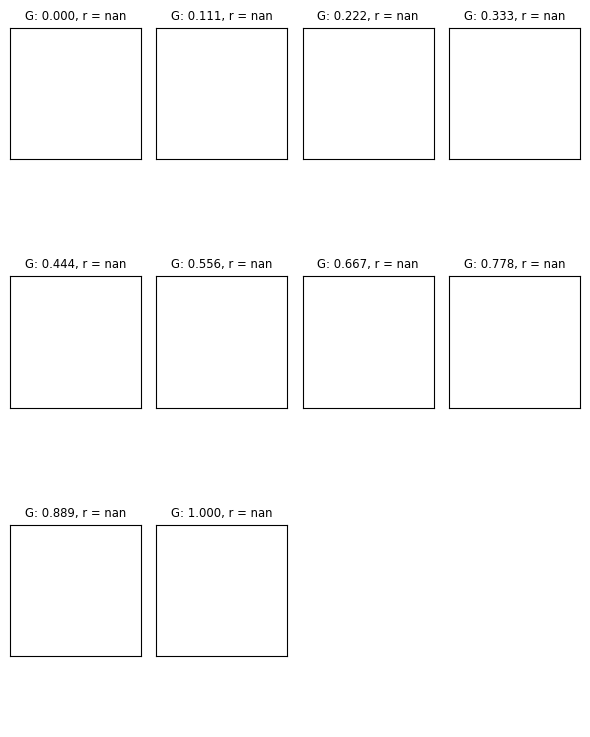

In [ ]:
def plot_fcs(fcs, rs):
    n_rows = int(np.ceil(np.sqrt(len(fcs))))
    n_cols = int(np.ceil(len(fcs) / n_rows))
    fig, axs = plt.subplots(n_cols, n_rows, figsize=(n_cols * 2, n_rows * 2))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i < len(fcs):
            im = ax.imshow(fcs[i], cmap="viridis", interpolation="none")
            ax.set_title(f"G: {G_range[i]:.3f}, r = {rs[i]:.3f}", fontsize="small")
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis("off")
    plt.tight_layout()


plot_fcs(fcs_mfm, fc_corr_mfm)

# Seed-region correlation maps

A common visualization of FC specific to a given is to pull out its row of the FC matrix and plot a colormap on the anatomy. We can do this will the simulated functional connectivity to identify which regions are highly coordinated with the seed region.

In [ ]:
from tvb.datatypes import cortex

ctx = cortex.Cortex.from_file()
ctx.region_mapping_data.connectivity = conn
rm = ctx.region_mapping


def plot_roi_corr_map(reg_name):
    roi = list(conn.ordered_labels).index(reg_name)
    cs_m = cs[2:].mean(axis=0)
    utils.multiview(
        cs_m[roi][rm], cortex=ctx, shaded=False, suptitle=reg_name, figsize=(10, 5)
    )

As a few examples of such maps, seeding in the left motor cortex, right ventrolateral prefront cortex, and right superior parietal cortex:

In [ ]:
for reg in "lM1 rPFCVL rPCS".split():
    plot_roi_corr_map(reg)

ValueError: 'lM1' is not in list

Seed-region maps are useful when one has a prior about which regions are implicated for a given network.

# ICA

Another common exploratory tool in resting state data analysis, where the implicated regions or networks are not known a priori, is independent component analysis, which extracts components with unique or independent statistical properties.

For exapmle, we can perform an ICA keeping 5 components the above simulated data,

In [ ]:
ica = FastICA(n_components=5, max_iter=250)
ica.fit(y[t > 2e3])

FastICA(max_iter=250, n_components=5)

And then visualize the different components

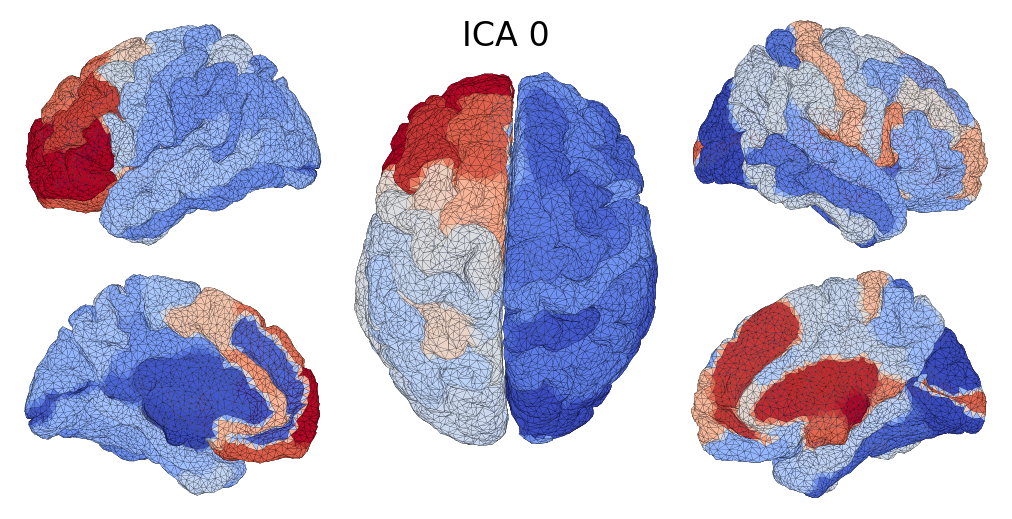

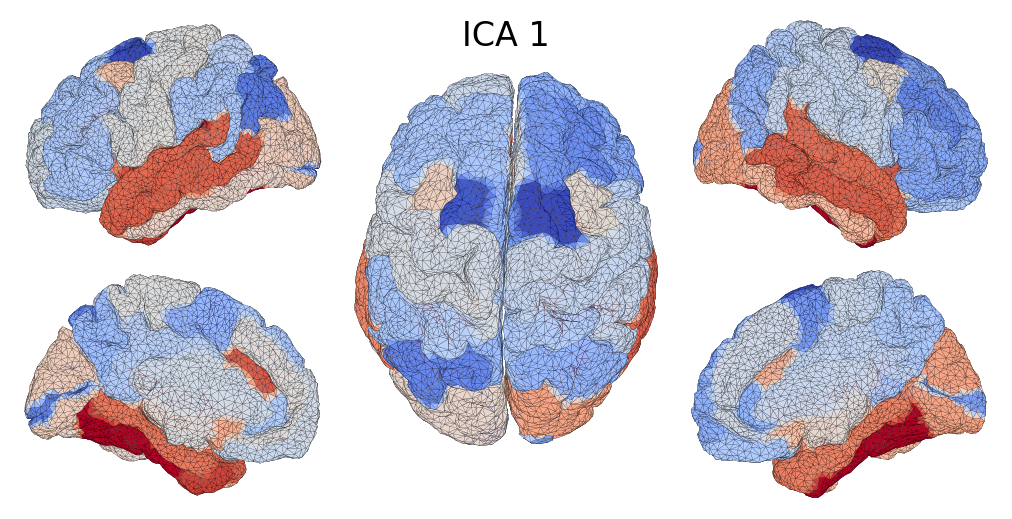

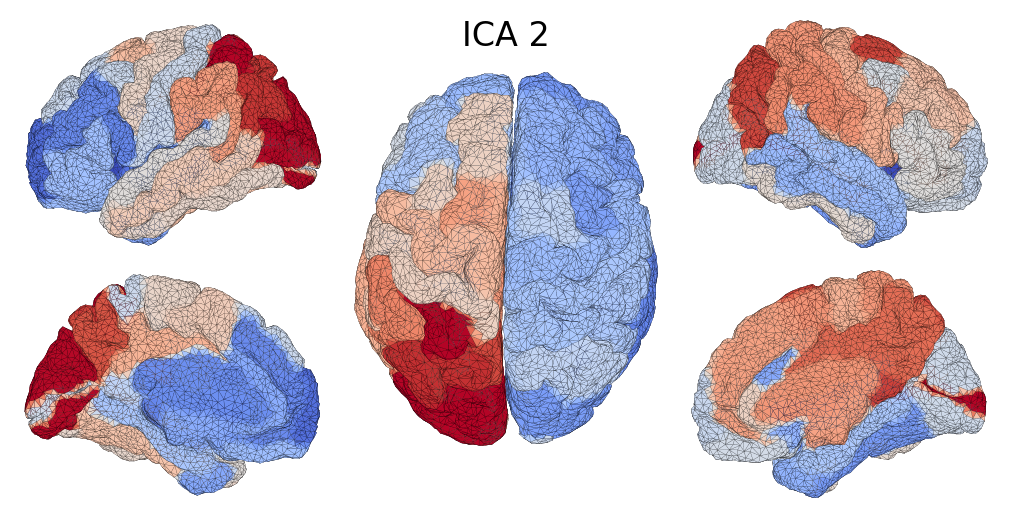

In [ ]:
for i, comp in enumerate(ica.components_[:3]):
    utils.multiview(
        comp[rm], cortex=ctx, shaded=False, suptitle="ICA %d" % (i,), figsize=(10, 5)
    )

These components are not selected 'by hand', but represent independent subnetworks during the simulated resting state activity.

Finally, we point out, that commonly ICA analyses of fMRI are done at a group level to identify spatial patterns which are reproducible across subjects, whereas in this application to this simulation, spatial components may reflect as much non-robust, spontaneous fluctuations of the network passing through various state as the dominant rest state networks identified in human rest state.

# Further exploration

These results are starting point, from which you can base you simulations, going in directions such as

- Perform a parameter sweep to identify regions of improved FC-SC correlation
- Introduce a subject specific structural connectivity and compare with subject specific functional connectivity
- Threshold the calculated functional connectivities and apply graph theoretic measures

We hope this has been a useful tutorial and welcome any comments or questions on our mailing list (https://groups.google.com/forum/#!forum/tvb-users).

# References

- [Damoiseaux, J. S., Rombouts, S. A. R. B., Barkhof, F., Scheltens, P., Stam, C. J., Smith, S. M., & Beckmann, C. F. (2006). Consistent resting-state networks across healthy subjects. Proceedings of the national academy of sciences, 103(37), 13848-13853.](http://www.pnas.org/content/103/37/13848.full)
- [Mantini, D., Perrucci, M. G., Del Gratta, C., Romani, G. L., & Corbetta, M. (2007). Electrophysiological signatures of resting state networks in the human brain. Proceedings of the National Academy of Sciences, 104(32), 13170-13175](https://www.pnas.org/content/104/32/13170.full)
- [Ghosh, A., Rho, Y., McIntosh, A. R., Kötter, R., & Jirsa, V. K. (2008). Noise during rest enables the exploration of the brain's dynamic repertoire. PLoS Comput Biol, 4(10), e1000196.](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000196)
- [Honey, C. J., Sporns, O., Cammoun, L., Gigandet, X., Thiran, J. P., Meuli, R., & Hagmann, P. (2009). Predicting human resting-state functional connectivity from structural connectivity. Proceedings of the National Academy of Sciences, 106(6), 2035-2040.](https://www.pnas.org/content/106/6/2035.full)
- [Deco, G., & Jirsa, V. K. (2012). Ongoing cortical activity at rest: criticality, multistability, and ghost attractors. The Journal of Neuroscience, 32(10), 3366-3375.](www.jneurosci.org/content/32/10/3366.short)
- [Hansen, E. C., Battaglia, D., Spiegler, A., Deco, G., & Jirsa, V. K. (2015). Functional connectivity dynamics: modeling the switching behavior of the resting state. Neuroimage, 105, 525-535.](http://www.sciencedirect.com/science/article/pii/S1053811914009033)